# Traffic Sign Recognition using CNN

In [35]:
import os
import zipfile
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from keras.layers.regularization.spatial_dropout3d import Dropout
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

## Dataset

> The dataset is hosted publically at https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html

In [36]:
#Fetch images deom GTSRB website
#Images for training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Images for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Labels for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

** Resuming transfer from byte position 276294756
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   314    0   314    0     0    478      0 --:--:-- --:--:-- --:--:--   477
** Resuming transfer from byte position 88978620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   314    0   314    0     0    605      0 --:--:-- --:--:-- --:--:--   603
** Resuming transfer from byte position 99620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   314    0   314    0     0    630      0 --:--:-- --:--:-- --:--:--   630


In [37]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
TESTING_DATA_DIR = "dataset/testing"

to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]

for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...


> All the image files in our dataset have an extension of `.ppm`. We need to convert them to `.jpg` files for our model.

In [38]:
# Collect all PPM files and their labels
tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(tmp_train_data_dir)
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Loop through the label directories and collect the data in two lists, labels and images.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f)
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)

# Let's have it sorted for better debugging.
ppm_files_train.sort()
ppm_labels_train.sort()

# Convert
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)

    image.save(os.path.join(directory, image_filename))

#Load testing set
tmp_testing_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")
tmp_testing_data_files = [f for f in os.listdir(tmp_testing_data_dir) if f.endswith(".ppm")]
testing_images = []

#export as JPGs
for ppm_file in tmp_testing_data_files:
    image_dir = os.path.join(tmp_testing_data_dir, ppm_file)
    image = Image.open(image_dir)
    directory = TESTING_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)

    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    testing_images.append(final_image)
    testing_images.sort()

> Let's visualize some images with the help of a helper function.

In [39]:
# Helper Function
def view_image(dir_path, class_name):
  """
    This is a helper function used to visualize images from our dataset.
    Args:
      dir_path   : Path of the directory where all the classes of images are stored in our directory structure.
      class_name : The class name of the image to be visualized

    Returns:
      Image array
  """
  # Construct path to the image
  img_path = dir_path + "/" + class_name
  # Select a random image in the directory
  random_img = random.sample(os.listdir(img_path), 1)
  # Read the image
  img = np.asarray(Image.open(img_path + "/" + random_img[0]))
  # Plot the image
  plt.imshow(img)

  return img

(109, 110, 3)

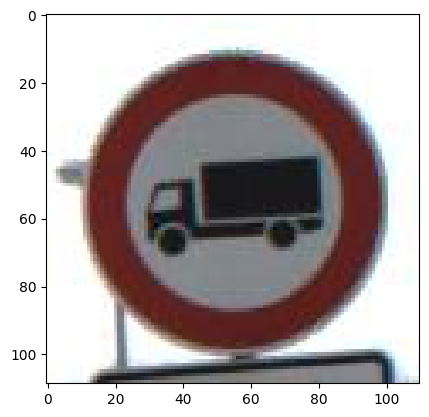

In [40]:
train_img = view_image(dir_path = TRAINING_DATA_DIR,
                       class_name = '00016')
train_img.shape

(36, 36, 3)

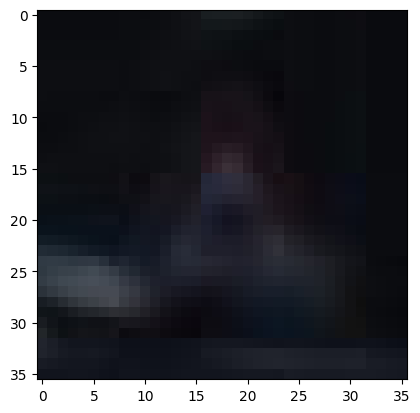

In [41]:
test_img = view_image(dir_path = TESTING_DATA_DIR,
                 class_name = "")
test_img.shape

In [42]:
# Label map
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

In [43]:
# Create function to generate data
def get_data_iterator(data_dir,
                      batch_size=32,
                      image_size=(224, 224),
                      class_names=None,
                      label_mode='int'):
  return image_dataset_from_directory(directory=data_dir,
                                      batch_size=batch_size,
                                      image_size=image_size,
                                      class_names=class_names,
                                      label_mode=label_mode)

In [44]:
# Create the training data
train_data = get_data_iterator(data_dir=TRAINING_DATA_DIR,
                               batch_size=32,
                               image_size=(32, 32),
                               label_mode='categorical')


tmp_validation_labels_csv = os.path.join(TMP_LABELS_DIR, "GT-final_test.csv")
val_data_frame = pd.read_csv(tmp_validation_labels_csv, header=0, sep=';')
val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg')
val_data_frame['ClassId'] = val_data_frame['ClassId'].astype(str).str.zfill(5)

Found 39209 files belonging to 43 classes.


<ipython-input-44-62098a120355>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg')


In [45]:
# Create testing and validation data
image_data_generator = ImageDataGenerator(validation_split=0.5)
test_data = image_data_generator.flow_from_dataframe(val_data_frame,
                                                     x_col='Filename',
                                                     directory=TESTING_DATA_DIR,
                                                     y_col='ClassId',
                                                     target_size=(32, 32),
                                                     subset='training')
valid_data = image_data_generator.flow_from_dataframe(val_data_frame,
                                                      x_col='Filename',
                                                      directory=TESTING_DATA_DIR,
                                                      y_col='ClassId',
                                                      target_size=(32, 32),
                                                      subset='validation')

Found 6315 validated image filenames belonging to 43 classes.
Found 6315 validated image filenames belonging to 43 classes.


## Model

In [47]:
# Set the random seed
tf.random.set_seed(42)

# Create model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(43, activation='softmax')
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Fit the model
history = model.fit(train_data,
                epochs=50,
                steps_per_epoch=len(train_data),
                validation_data=valid_data,
                validation_steps=len(valid_data))

Epoch 1/50
1226/1226 [==============================] - 94s 73ms/step - loss: 1.6143 - accuracy: 0.5237 - val_loss: 0.5718 - val_accuracy: 0.8315
Epoch 2/50
1226/1226 [==============================] - 80s 65ms/step - loss: 0.3945 - accuracy: 0.8745 - val_loss: 0.3176 - val_accuracy: 0.9112
Epoch 3/50
1226/1226 [==============================] - 80s 65ms/step - loss: 0.2268 - accuracy: 0.9275 - val_loss: 0.2934 - val_accuracy: 0.9175
Epoch 4/50
1226/1226 [==============================] - 79s 65ms/step - loss: 0.1670 - accuracy: 0.9471 - val_loss: 0.2679 - val_accuracy: 0.9275
Epoch 5/50
1226/1226 [==============================] - 80s 65ms/step - loss: 0.1401 - accuracy: 0.9556 - val_loss: 0.2135 - val_accuracy: 0.9411
Epoch 6/50
1226/1226 [==============================] - 87s 71ms/step - loss: 0.1198 - accuracy: 0.9638 - val_loss: 0.2287 - val_accuracy: 0.9408
Epoch 7/50
1226/1226 [==============================] - 79s 65ms/step - loss: 0.1087 - accuracy: 0.9649 - val_loss: 0.2602 -

## Visualize the loss and accuracy curves

Text(0, 0.5, 'Accuracy')

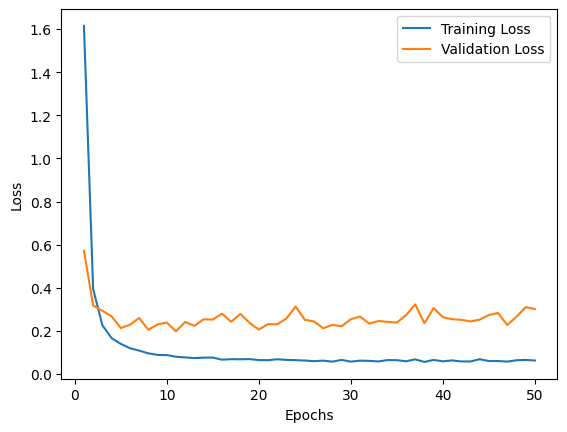

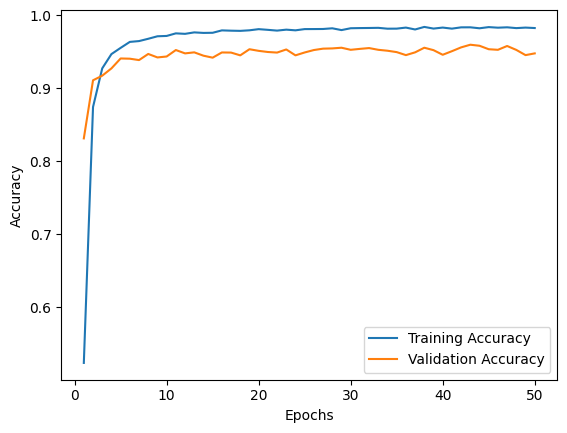

In [48]:
epochs = np.arange(1, 51, 1, dtype=int)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure()
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Testing Evaluation

In [49]:
model.evaluate(test_data)

198/198 [==============================] - 10s 51ms/step - loss: 0.2984 - accuracy: 0.9460


[0.29835692048072815, 0.9460015892982483]

> As shown above, the model has a 94.6 % accuracy on the `Testing Dataset`